In [1]:
import pandas as pd
import numpy as np
import yaml
import hydra
from hydra.utils import instantiate
import os
import matplotlib.pyplot as plt
import seaborn as sns
from omegaconf import DictConfig, OmegaConf
import torch
import torch.nn.functional as F
from scipy.stats import entropy

In [2]:
# Configuration dictionary
CONFIG_PATH = 'config'
CONFIG_NAME = 'runner_report'
hydra.core.global_hydra.GlobalHydra.instance().clear()
hydra.initialize(config_path=CONFIG_PATH)
cfg = hydra.compose(config_name=CONFIG_NAME)

In [3]:
file_path = '/home/sgwang/nuplan/exp/exp/simulation/open_loop_boxes/test/planTF'
def get_report_with_metrics(file_path):
    # read the runner report
    runner_report = os.path.join(file_path, 'runner_report.parquet')
    df = pd.read_parquet(runner_report)
    df = df[['scenario_type', 'scenario_name', 'log_name', 'risk_score', 'ood_score']]
    # read the metric files

    files=['metrics/planner_expert_average_heading_error_within_bound.parquet',
    'metrics/planner_expert_average_l2_error_within_bound.parquet',
    'metrics/planner_expert_final_heading_error_within_bound.parquet',
    'metrics/planner_expert_final_l2_error_within_bound.parquet',
    'metrics/planner_miss_rate_within_bound.parquet']

    for i in range(len(files)-1):
        # get the log_name, scenario_name, and the metric_score columns from the metric files
        metric_report = os.path.join(file_path, files[i])
        df_metric = pd.read_parquet( metric_report)
        df_metric = df_metric[['scenario_name', 'metric_score']]
        # merge the runner report and the metric files
        df = pd.merge(df, df_metric, on=['scenario_name'])
        # rename the metric_score as metric_score_{}.format(i)
        df.rename(columns={'metric_score': 'metric_score_{}'.format(i)}, inplace=True)
    # print the first 5 rows of the merged DataFrame
    return df

In [4]:
def read_report(cfg:DictConfig)-> pd.DataFrame:
    runner_report_file = os.path.join(cfg.output_dir, 'runner_report.parquet')
    # Read the Parquet file
    df = pd.read_parquet(runner_report_file)
    return df
    
def load_scenario_types(yaml_file):
    with open(yaml_file, 'r') as file:
        data = yaml.safe_load(file)
    return set(data['scenario_types'])

def load_scenario_types_from_csv():
    scenario_types = pd.read_csv('scenario_type_counts.csv')['scenario_type'].values
    return set(scenario_types)

def label_scenarios(df: pd.DataFrame, scenario_types) -> pd.DataFrame:
    df['scenario_distribution'] = df['scenario_type'].apply(lambda x: 'InD' if x in scenario_types else 'OOD')
    return df

def calculate_average_metric_score(df: pd.DataFrame) -> pd.DataFrame:
    df['metric_score_avg'] = df[['metric_score_0', 'metric_score_1', 'metric_score_2', 'metric_score_3']].mean(axis=1)
    return df

def label_low_score(df):
    df['low_score'] = df['metric_score_avg'] < df['metric_score_avg'].mean()
    return df

def calculate_energy_score(df: pd.DataFrame) -> pd.DataFrame:
    # Initialize a list to store ood_scores for all rows
    ood_score = []
    # Iterate over 'risk_score' column in the DataFrame
    for i in df['risk_score']:
        # For each row, calculate the ood_score for each 'j' and store in a list
        raw_ood_score = [np.log(np.sum(np.exp(j))) for j in i]
        # Take the mean of the row's ood_scores (or any other aggregation if needed)
        # ood_score.append(np.mean(row_ood_score))
        ood_score.append(raw_ood_score)
    # Assign the ood_score list to the new column 'ood_score_np'
    df['score'] = ood_score
    return df

def calculate_msp_score(df: pd.DataFrame) -> pd.DataFrame:
    ood_score = []
    for i in df['risk_score']:
        # Convert each NumPy array `x` to a PyTorch tensor
        raw_score = [np.max(F.softmax(torch.tensor(x), dim=0).numpy()) for x in i]
        ood_score.append(raw_score)
    df['score'] = ood_score
    return df

def calculate_average_ood_score(df: pd.DataFrame) -> pd.DataFrame:
    df['ood_score_avg'] = df['score'].apply(lambda x: np.mean(x))
    return df

def calculate_max_ood_score(df: pd.DataFrame) -> pd.DataFrame:
    df['ood_score_max'] = df['score'].apply(lambda x: np.max(x))
    return df

def calculate_min_ood_score(df: pd.DataFrame) -> pd.DataFrame:
    df['ood_score_min'] = df['score'].apply(lambda x: np.min(x))
    return df

def calculate_std_ood_score(df: pd.DataFrame) -> pd.DataFrame:
    df['ood_score_std'] = df['score'].apply(lambda x: np.std(x))
    return df

def calculate_var_ood_score(df: pd.DataFrame) -> pd.DataFrame:
    df['ood_score_var'] = df['score'].apply(lambda x: np.var(x))
    return df
 
def filter_df_by_ood_score(df):
    return df[(df['ood_score_avg'] >= 2.5) & (df['ood_score_avg'] <= 3.5)]

In [5]:
def relabel_scenarios(df: pd.DataFrame, label) -> pd.DataFrame:
    scenarios = [
        'stopping_at_stop_sign_without_lead', 'starting_unprotected_noncross_turn',
        'starting_protected_cross_turn', 'on_carpark', 'on_pickup_dropoff', 
        'on_intersection', 'on_stopline_traffic_light', 'stopping_at_crosswalk', 
        'high_lateral_acceleration', 'traversing_pickup_dropoff', 
        'starting_protected_noncross_turn', 'on_traffic_light_intersection', 
        'following_lane_without_lead', 
        'starting_straight_traffic_light_intersection_traversal'
    ]
    
 
    df['scenario_distribution'] = np.where(
        df['scenario_type'].isin(scenarios),   
        label,                                
        df['scenario_distribution']            
    )
    return df

In [6]:
def get_mean_score(df: pd.DataFrame) -> pd.DataFrame:
    ood_score = []
    for i in df['risk_score']:
        # Convert each NumPy array `x` to a PyTorch tensor
        raw_ood_score = [np.mean(j) for j in i]
        ood_score.append(raw_ood_score)
    df['score'] = ood_score
    return df

def get_exp_mean_score(df: pd.DataFrame) -> pd.DataFrame:
    ood_score = []
    for i in df['risk_score']:
        # Convert each NumPy array `x` to a PyTorch tensor
        raw_ood_score = [np.log(np.mean(np.exp(j))) for j in i]
        ood_score.append(raw_ood_score)
    df['score'] = ood_score
    return df

def get_var_score(df: pd.DataFrame) -> pd.DataFrame:
    ood_score = []
    for i in df['risk_score']:
        # Convert each NumPy array `x` to a PyTorch tensor
        raw_ood_score = [np.var(j) for j in i]
        ood_score.append(raw_ood_score)
    df['score'] = ood_score
    return df

def get_plus_score(df: pd.DataFrame) -> pd.DataFrame:
    ood_score = []
    for i in df['risk_score']:
        # Convert each NumPy array `x` to a PyTorch tensor
        raw_ood_score = [(np.var(j)+np.mean(j)) for j in i]
        ood_score.append(raw_ood_score)
    df['score'] = ood_score
    return df

def get_min_score(df: pd.DataFrame) -> pd.DataFrame:
    ood_score = []
    for i in df['risk_score']:
        # Convert each NumPy array `x` to a PyTorch tensor
        raw_ood_score = [(np.max(j)-np.mean(j)) for j in i]
        ood_score.append(raw_ood_score)
    df['score'] = ood_score
    return df

def get_entropy_score(df: pd.DataFrame) -> pd.DataFrame:
    ood_score = []
    for i in df['risk_score']:
        # Convert each NumPy array `x` to a PyTorch tensor
        raw_ood_score = [entropy(j) for j in i]
        ood_score.append(raw_ood_score)
    df['score'] = ood_score
    return df

In [7]:
def draw_distribution(df: pd.DataFrame, score: str) -> None:
    plt.figure(figsize=(10, 6))
    # df[score] = df[score].apply(lambda x: x.item())
    sns.kdeplot(data=df[df['scenario_distribution'] == 'InD'], 
                x=score, 
                fill=True, 
                color='blue', 
                label='InD', 
                alpha=0.5)

    sns.kdeplot(data=df[df['scenario_distribution'] == 'OOD'], 
                x=score, 
                fill=True, 
                color='red', 
                label='OOD', 
                alpha=0.5)
    plt.grid(True)
    plt.title('Scenario Distribution')
    plt.xlabel('score')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

def draw_risk(df: pd.DataFrame, score: str) -> None:
    plt.figure(figsize=(10, 6))
    # df[score] = df[score].apply(lambda x: x.item())
    sns.kdeplot(data=df[df['low_score'] == False], 
                x=score, 
                fill=True, 
                color='blue', 
                label='Low Risk', 
                alpha=0.5)

    sns.kdeplot(data=df[df['low_score'] == True], 
                x=score, 
                fill=True, 
                color='red', 
                label='High Risk', 
                alpha=0.5)
    plt.grid(True)
    plt.title('Scenario Distribution')
    plt.xlabel('score')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

In [8]:
def filter_df(df):
    return df[df['metric_score_avg'] < df['metric_score_avg'].mean()]

In [9]:
df = get_report_with_metrics(file_path)
scenario_types = load_scenario_types_from_csv()
df = label_scenarios(df, scenario_types)
df = calculate_average_metric_score(df)
df = label_low_score(df)

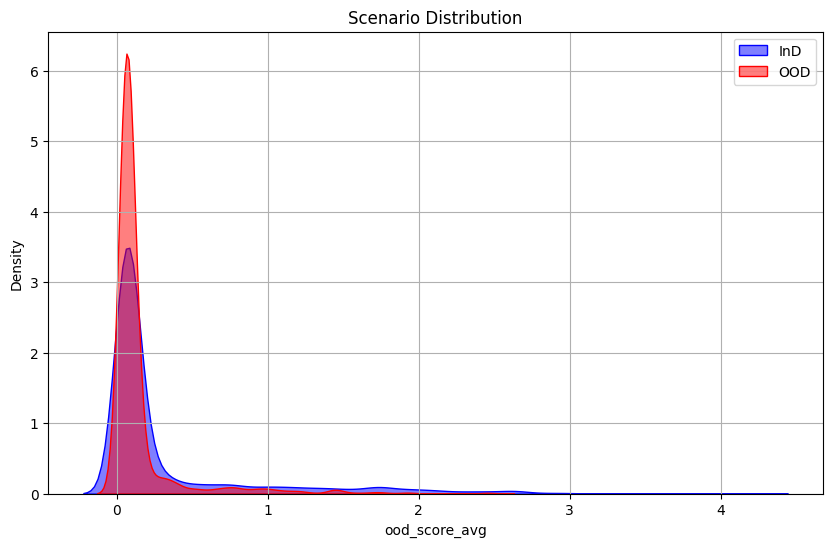

In [13]:
df = get_mean_score_with_temperature_scaling(df, temperature=5)
df = calculate_average_ood_score(df)
draw_distribution(df, 'ood_score_avg')

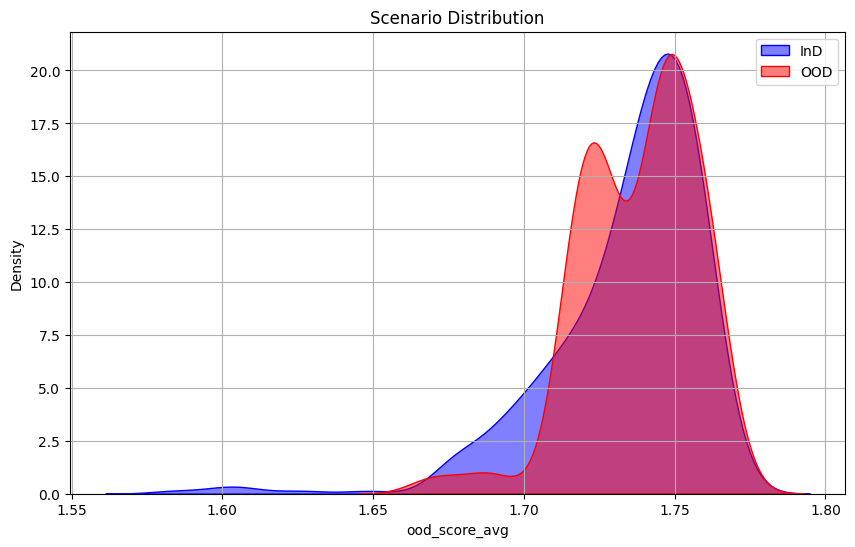

In [114]:
df = get_entropy_score(df)
df = calculate_average_ood_score(df)
draw_distribution(df, 'ood_score_avg')

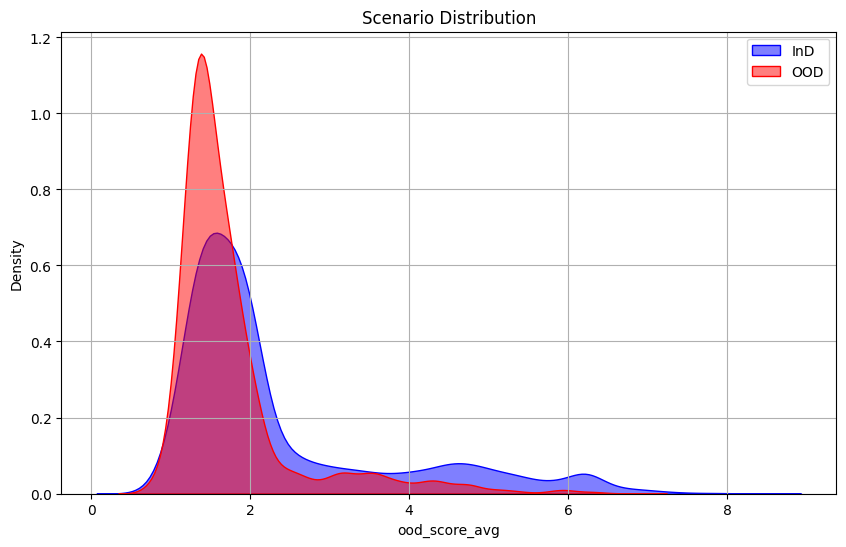

In [16]:
df = get_exp_mean_score(df)
df = calculate_average_ood_score(df)
draw_distribution(df, 'ood_score_avg')

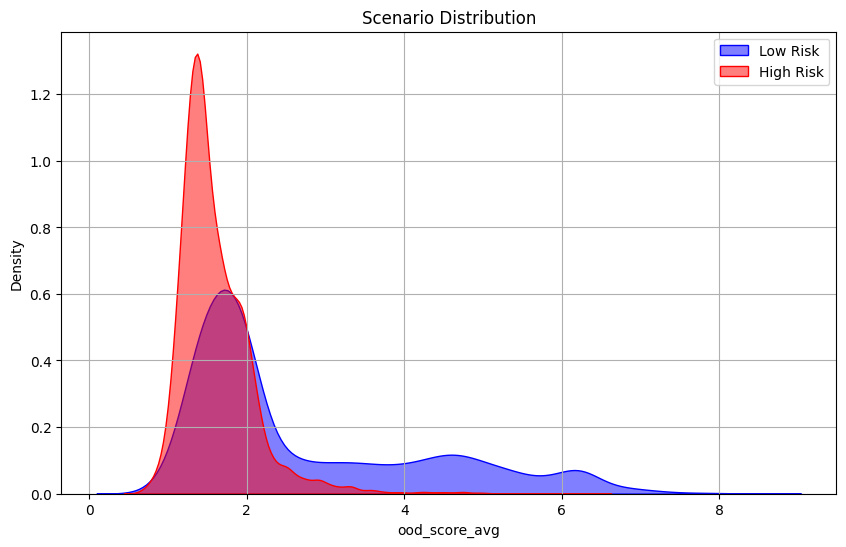

In [17]:
draw_risk(df, 'ood_score_avg')

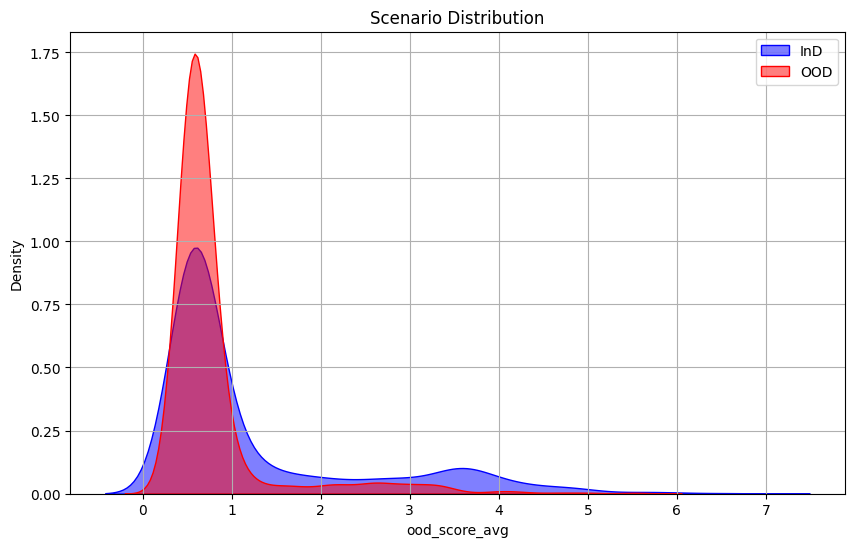

In [110]:
df = get_min_score(df)
df = calculate_average_ood_score(df)
draw_distribution(df, 'ood_score_avg')

In [13]:
def draw_performance(df: pd.DataFrame, score: str) -> None:
    plt.figure(figsize=(10, 6))
    # df[score] = df[score].apply(lambda x: x.item())
    sns.kdeplot(data=df[df['scenario_distribution'] == 'InD'], 
                x=score, 
                fill=True, 
                color='blue', 
                label='InD', 
                alpha=0.5)

    sns.kdeplot(data=df[df['scenario_distribution'] == 'OOD'], 
                x=score, 
                fill=True, 
                color='red', 
                label='OOD', 
                alpha=0.5)
    plt.grid(True)
    plt.title('Performance score distribution')
    plt.xlabel('performance')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

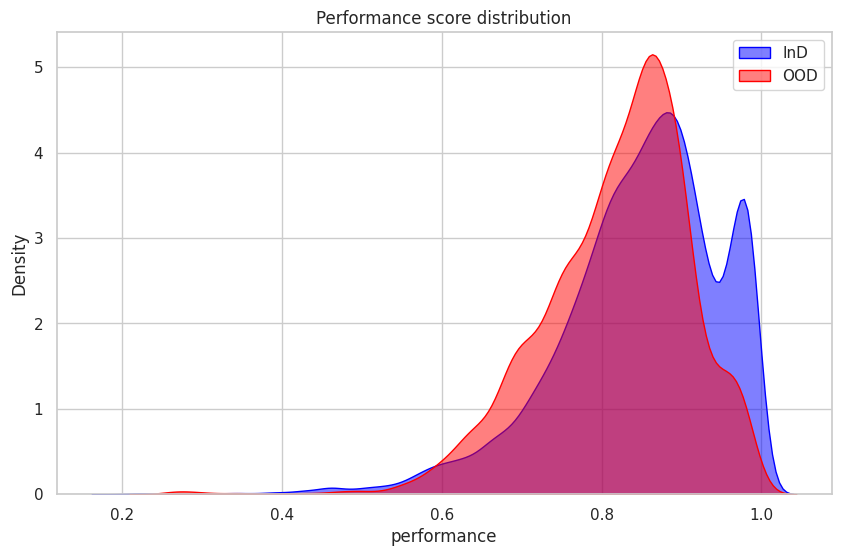

In [14]:
draw_performance(df, 'metric_score_avg')

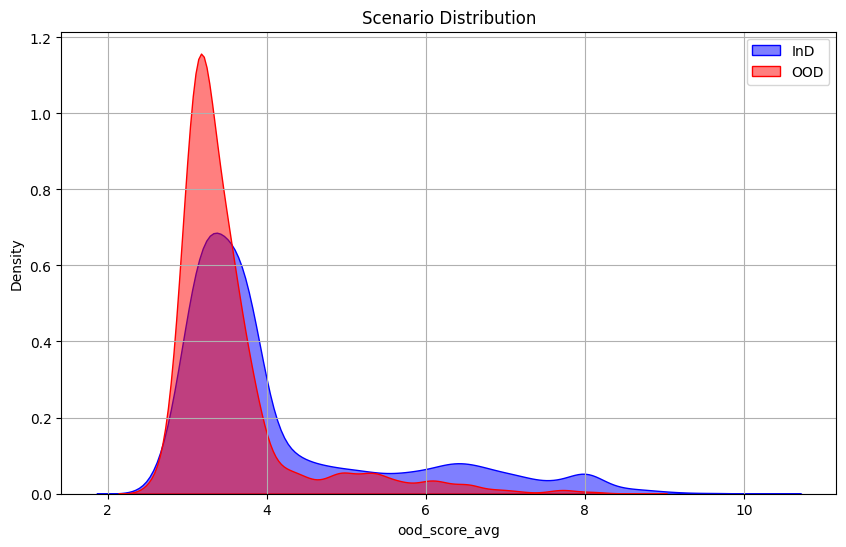

In [28]:
df = calculate_energy_score(df)
df = calculate_average_ood_score(df)
draw_distribution(df, 'ood_score_avg')

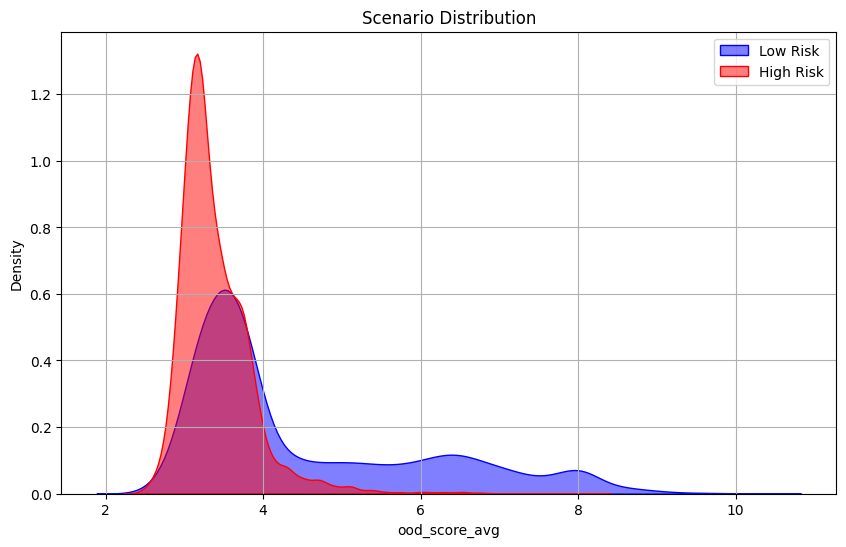

In [29]:
draw_risk(df, 'ood_score_avg')

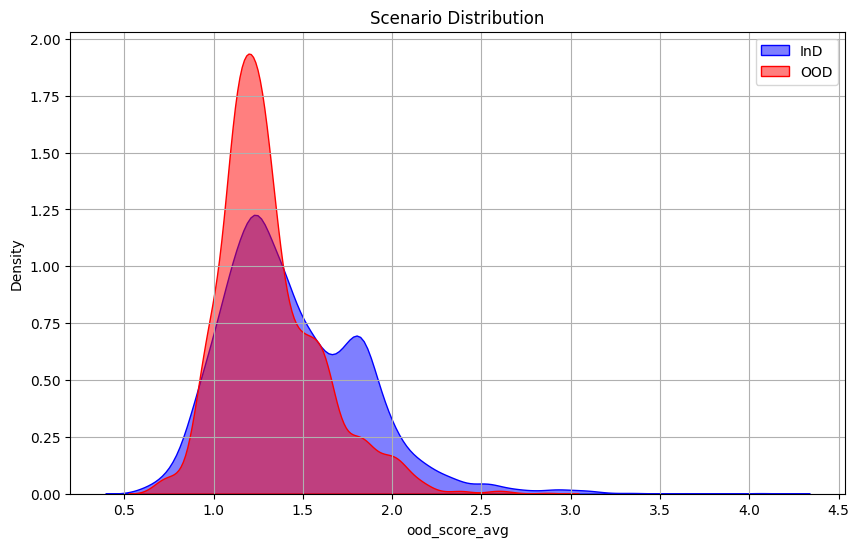

In [31]:
df = get_mean_score(df)
df = calculate_average_ood_score(df)
df = filter_df(df)
draw_distribution(df, 'ood_score_avg')

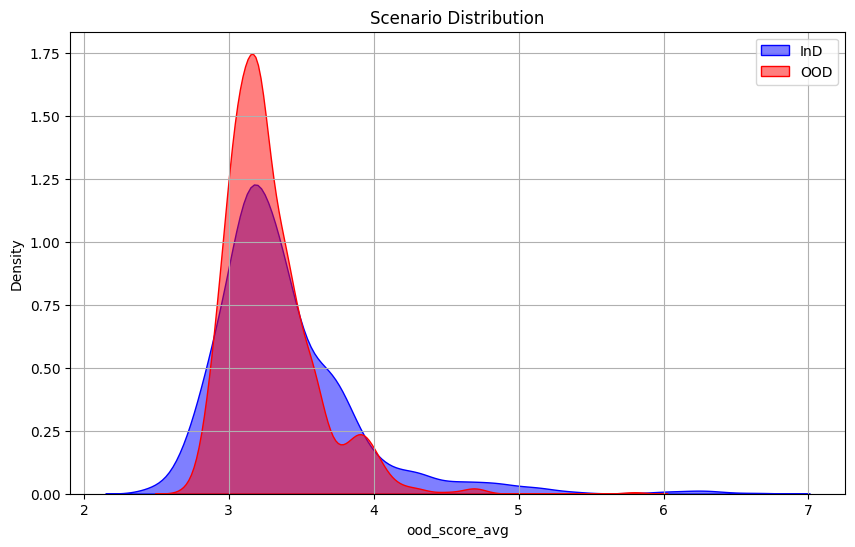

In [32]:
df = calculate_energy_score(df)
df = calculate_average_ood_score(df)
df = filter_df(df)
draw_distribution(df, 'ood_score_avg')

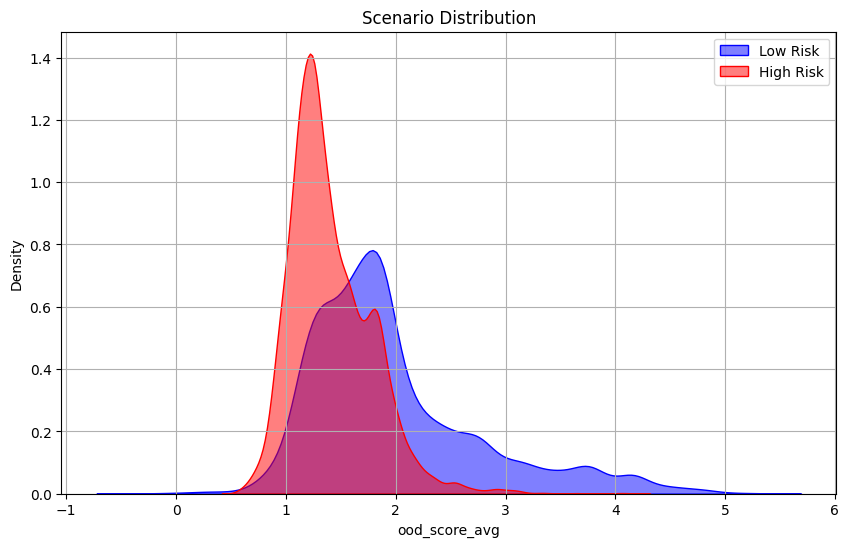

In [27]:
draw_risk(df, 'ood_score_avg')

In [16]:
def get_max_score(df: pd.DataFrame) -> pd.DataFrame:
    ood_score = []
    for i in df['risk_score']:
        # Convert each NumPy array `x` to a PyTorch tensor
        raw_ood_score = [np.max(j) for j in i]
        ood_score.append(raw_ood_score)
    df['score'] = ood_score
    return df

In [93]:
df = get_raw_score(df)
df = calculate_average_ood_score(df)

scenario_type                                      traversing_intersection
scenario_name                                             000c4693cc145d3e
log_name                            2021.09.22.06.36.13_veh-53_01137_01583
risk_score               [[0.7103542, 1.2559798, 1.0788375, 1.2375239, ...
ood_score                [[2.6526465], [2.6372857], [2.6357017], [2.639...
metric_score_0                                                    0.934693
metric_score_1                                                    0.870722
metric_score_2                                                    0.919105
metric_score_3                                                    0.751335
scenario_distribution                                                  InD
metric_score_avg                                                  0.868964
low_score                                                            False
score                    [0.7479257, 0.695224, 0.68040675, 0.6812503, 0...
Name: 0, dtype: object


In [98]:
df = get_var_score(df)
df = calculate_average_ood_score(df)

In [87]:
df = calculate_msp_score(df)
df = calculate_average_ood_score(df)

In [88]:
relabel_df = relabel_scenarios(df, scenario_types, 'others')

In [22]:
# filter the DataFrame where the metric_score_avg is less than mean of the metric_score_avg,
def filter_df(df):
    return df[df['metric_score_avg'] < df['metric_score_avg'].mean()]

In [23]:
filtered_df = filter_df(df)

In [136]:
# files=['/home/sgwang/nuplan/exp/exp/simulation/open_loop_boxes/test/planTF/metrics/planner_expert_average_heading_error_within_bound.parquet',
# '/home/sgwang/nuplan/exp/exp/simulation/open_loop_boxes/test/planTF/metrics/planner_expert_average_l2_error_within_bound.parquet',
# '/home/sgwang/nuplan/exp/exp/simulation/open_loop_boxes/test/planTF/metrics/planner_expert_final_heading_error_within_bound.parquet',
# '/home/sgwang/nuplan/exp/exp/simulation/open_loop_boxes/test/planTF/metrics/planner_expert_final_l2_error_within_bound.parquet',
# '/home/sgwang/nuplan/exp/exp/simulation/open_loop_boxes/test/planTF/metrics/planner_miss_rate_within_bound.parquet']

files=['/home/sgwang/nuplan/exp/exp/simulation/open_loop_boxes/test_all/planTF/metrics/planner_expert_average_heading_error_within_bound.parquet',
'/home/sgwang/nuplan/exp/exp/simulation/open_loop_boxes/test_all/planTF/metrics/planner_expert_average_l2_error_within_bound.parquet',
'/home/sgwang/nuplan/exp/exp/simulation/open_loop_boxes/test_all/planTF/metrics/planner_expert_final_heading_error_within_bound.parquet',
'/home/sgwang/nuplan/exp/exp/simulation/open_loop_boxes/test_all/planTF/metrics/planner_expert_final_l2_error_within_bound.parquet',
'/home/sgwang/nuplan/exp/exp/simulation/open_loop_boxes/test_all/planTF/metrics/planner_miss_rate_within_bound.parquet']

def below_average_counts(files) -> pd.DataFrame:
    # Initialize a list to store counts for all rows
    final_result_df = pd.DataFrame()
    for iter, metric_file in enumerate(files):
        df = pd.read_parquet(metric_file)
        below_average_count = []
        overall_average = df['metric_score'].mean()
        df['average_score'] = overall_average
        below_average_counts = df[df['metric_score'] < df['average_score']].groupby('scenario_type').size().reset_index(name='below_average_count_{}'.format(iter))
        mean_scores = df.groupby('scenario_type')['metric_score'].mean().reset_index(name='mean_score_{}'.format(iter))
        result_df = pd.merge(below_average_counts, mean_scores, on='scenario_type', how='outer').fillna(0)
        if final_result_df.empty:
            final_result_df = result_df
        else:
            final_result_df = pd.merge(final_result_df, result_df, on='scenario_type', how='outer').fillna(0)
        # Sum the below_average_counts and mean_scores
    final_result_df['total_below_average_count'] = final_result_df.filter(like='below_average_count_').sum(axis=1)
    final_result_df['total_mean_score'] = final_result_df.filter(like='mean_score_').mean(axis=1)
    return  final_result_df

def sort_by_scenario_type(df: pd.DataFrame) -> pd.DataFrame:
    # Sort by total_below_average_count descending and total_mean_score ascending
    sorted_df = df.sort_values(by=['total_mean_score'], ascending=[True])
    return sorted_df

# Example call
# def sort_by_scenario_type(df: pd.DataFrame) -> pd.DataFrame:
#     # Sort by total_below_average_count descending and total_mean_score ascending
#     sorted_df = df.sort_values(by=['total_below_average_count'], ascending=[False])
#     return sorted_df

# def sort_by_scenario_type(df: pd.DataFrame) -> pd.DataFrame:
#     # Sort by total_below_average_count descending and total_mean_score ascending
#     sorted_df = df.sort_values(by=['total_below_average_count', 'total_mean_score'], ascending=[False, True])
#     return sorted_df, highest_below_average_count, lowest_mean_score
    
final_result_df = below_average_counts(files)
sorted_df= sort_by_scenario_type(final_result_df)
sorted_df.to_csv('final.csv')
# print("Sorted Result DataFrame:")
# print(sorted_df)

In [81]:
print(relabel_df['scenario_distribution'].value_counts())

scenario_distribution
OOD    1289
InD    1150
Name: count, dtype: int64


In [95]:
print(df['scenario_distribution'].value_counts())

scenario_distribution
InD    1689
OOD     750
Name: count, dtype: int64


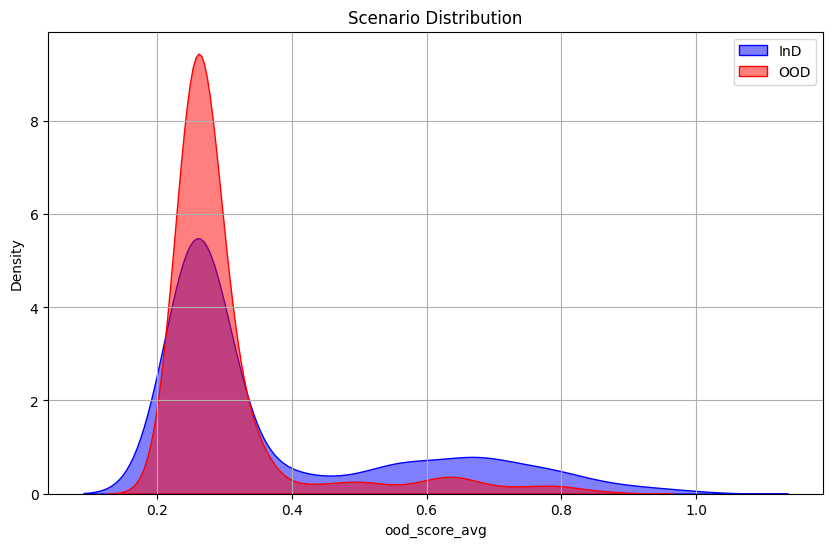

In [89]:
draw_distribution(relabel_df, 'ood_score_avg')

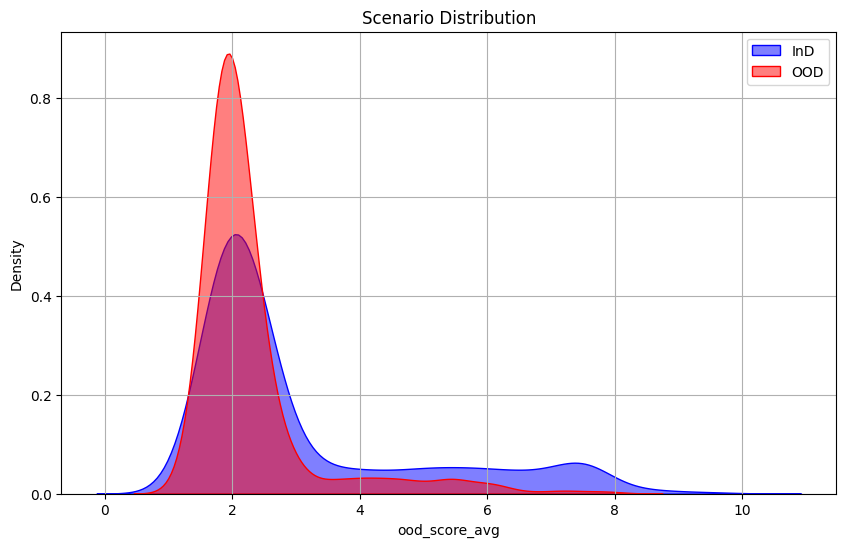

In [101]:
df = get_max_score(df)
df = calculate_average_ood_score(df)
draw_distribution(df, 'ood_score_avg')

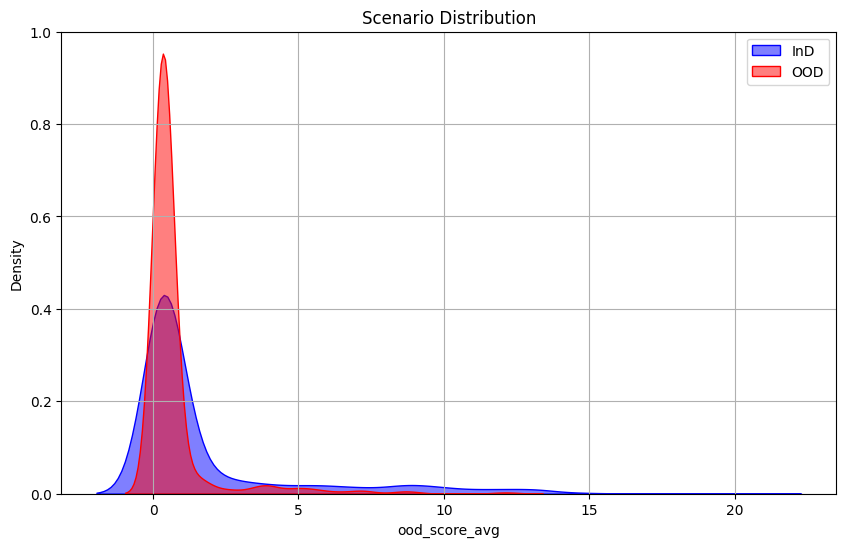

In [99]:
draw_distribution(df, 'ood_score_avg')

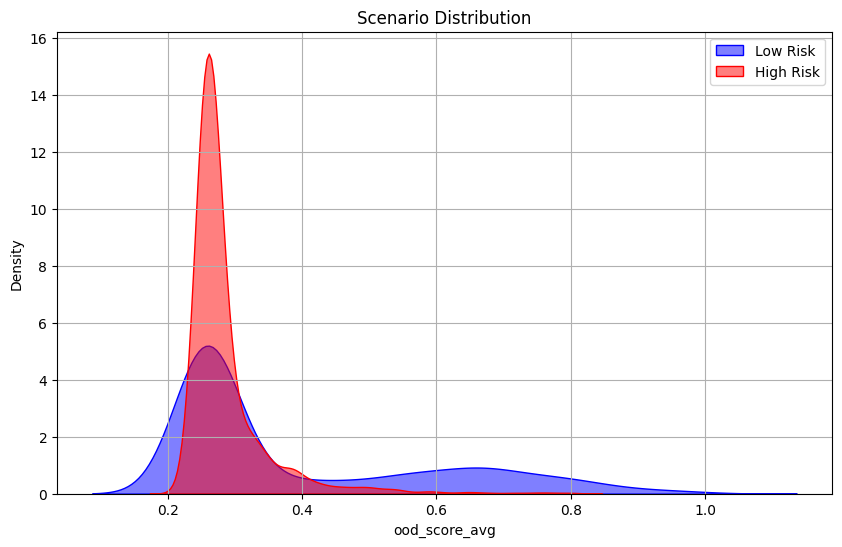

In [21]:
draw_risk(df, 'ood_score_avg')

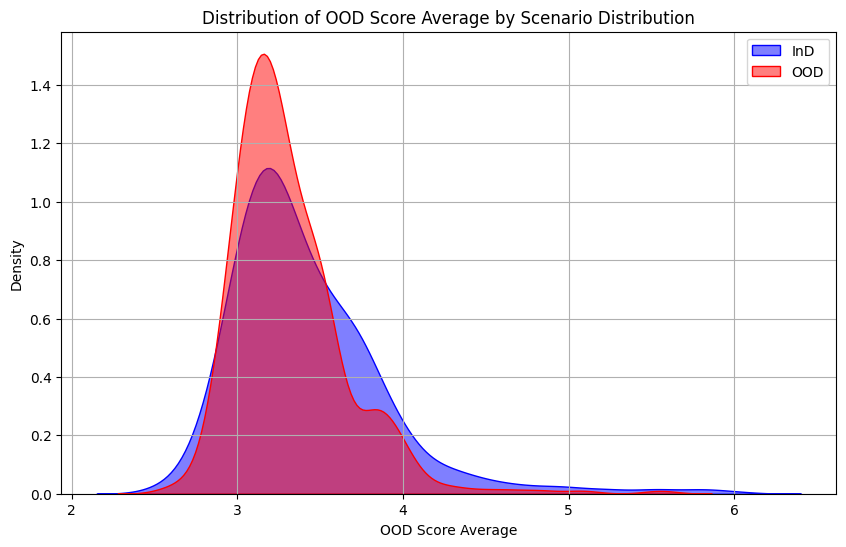

In [101]:
plt.figure(figsize=(10, 6))
df['ood_score_avg'] = df['ood_score_avg'].apply(lambda x: x.item())
sns.kdeplot(data=df[df['scenario_distribution'] == 'InD'], 
             x='ood_score_avg', 
             fill=True, 
             color='blue', 
             label='InD', 
             alpha=0.5)

sns.kdeplot(data=df[df['scenario_distribution'] == 'OOD'], 
             x='ood_score_avg', 
             fill=True, 
             color='red', 
             label='OOD', 
             alpha=0.5)
plt.grid(True)
plt.title('Distribution of OOD Score Average by Scenario Distribution')
plt.xlabel('OOD Score Average')
plt.ylabel('Density')
plt.legend()
plt.show()

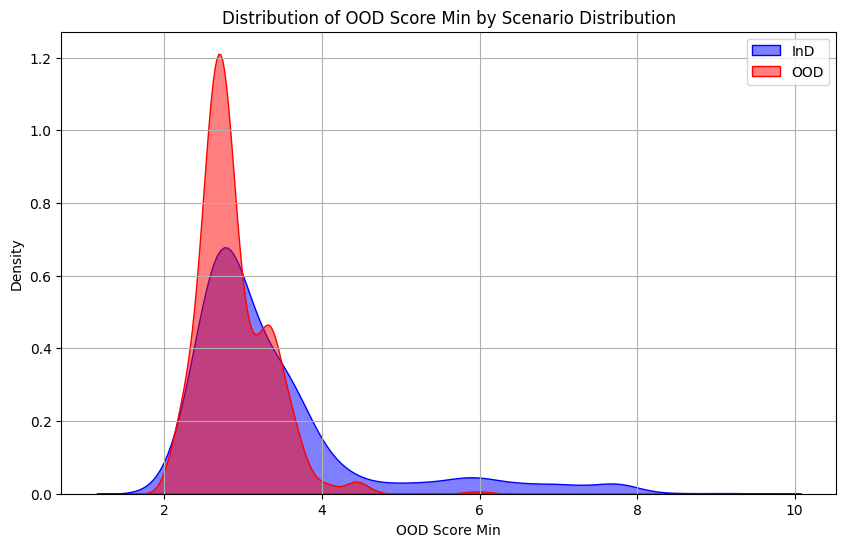

In [29]:
plt.figure(figsize=(10, 6))
df['ood_score_min'] = df['ood_score_min'].apply(lambda x: x.item())
sns.kdeplot(data=df[df['scenario_distribution'] == 'InD'], 
             x='ood_score_min', 
             fill=True, 
             color='blue', 
             label='InD', 
             alpha=0.5)

sns.kdeplot(data=df[df['scenario_distribution'] == 'OOD'], 
             x='ood_score_min', 
             fill=True, 
             color='red', 
             label='OOD', 
             alpha=0.5)
plt.grid(True)
plt.title('Distribution of OOD Score Min by Scenario Distribution')
plt.xlabel('OOD Score Min')
plt.ylabel('Density')
plt.legend()
plt.show()

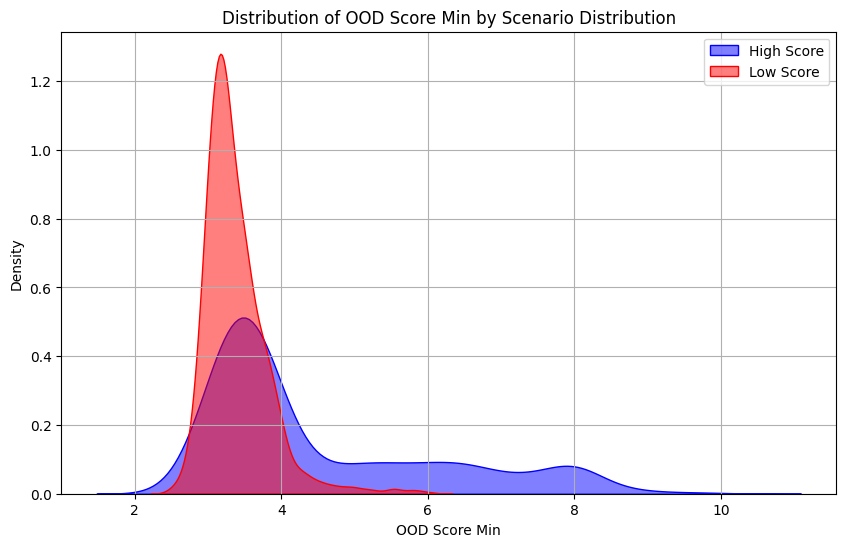

In [119]:
plt.figure(figsize=(10, 6))
#df['ood_score_avg'] = df['ood_score_avg'].apply(lambda x: x.item())
sns.kdeplot(data=df[df['low_score'] == False], 
             x= 'ood_score_avg', 
             fill=True, 
             color='blue', 
             label='High Score', 
             alpha=0.5)

sns.kdeplot(data=df[df['low_score'] == True], 
             x='ood_score_avg', 
             fill=True, 
             color='red', 
             label='Low Score', 
             alpha=0.5)
plt.grid(True)
plt.title('Distribution of OOD Score Min by Scenario Distribution')
plt.xlabel('OOD Score Min')
plt.ylabel('Density')
plt.legend()
plt.show()

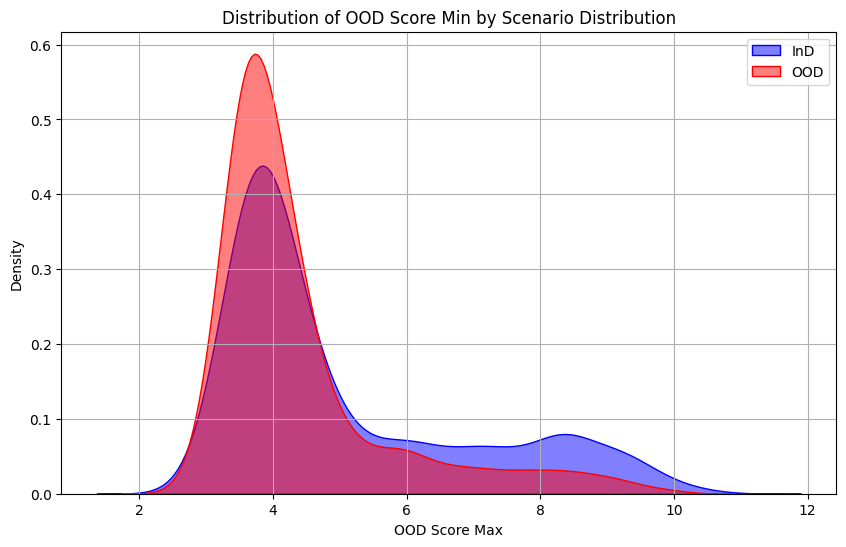

In [40]:
plt.figure(figsize=(10, 6))
df['ood_score_max'] = df['ood_score_max'].apply(lambda x: x.item())
sns.kdeplot(data=df[df['scenario_distribution'] == 'InD'], 
             x='ood_score_max', 
             fill=True, 
             color='blue', 
             label='InD', 
             alpha=0.5)

sns.kdeplot(data=df[df['scenario_distribution'] == 'OOD'], 
             x='ood_score_max', 
             fill=True, 
             color='red', 
             label='OOD', 
             alpha=0.5)
plt.grid(True)
plt.title('Distribution of OOD Score Min by Scenario Distribution')
plt.xlabel('OOD Score Max')
plt.ylabel('Density')
plt.legend()
plt.show()